## The Reuters Corpus

Revisit the Reuters C50 text corpus that we briefly explored in class. Your task is simple: tell an interesting story, anchored in some analytical tools we have learned in this class, using this data. For example:

- You could cluster authors or documents and tell a story about what you find.
- You could look for common factors using PCA.
- You could train a predictive model and assess its accuracy, constructing features for each document that maximize performance.
- You could do anything else that strikes you as interesting with this data.

Describe clearly what question you are trying to answer, what models you are using, how you pre-processed the data, and so forth. Make sure you include at least one really interesting plot (although more than one might be necessary, depending on your question and approach).

Format your write-up in the following sections, some of which might be quite short:

- **Question:** What question(s) are you trying to answer?
- **Approach:** What approach/statistical tool did you use to answer the questions?
- **Results:** What evidence/results did your approach provide to answer the questions? (E.g., any numbers, tables, figures as appropriate.)
- **Conclusion:** What are your conclusions about your questions? Provide a written interpretation of your results, understandable to stakeholders who might plausibly take an interest in this data set.

### Regarding the data itself:

In the `C50train` directory, you have 50 articles from each of 50 different authors (one author per directory). Then in the `C50test` directory, you have another 50 articles from each of those same 50 authors (again, one author per directory). This train/test split is obviously intended for building predictive models, but to repeat, you need not do that on this problem. You can tell any story you want using any methods you want. Just make it compelling!

**Note:** If you try to build a predictive model, you will need to figure out a way to deal with words in the test set that you never saw in the training set. This is a nontrivial aspect of the modeling exercise. (E.g., you might simply ignore those new words.)

### This question will be graded according to three criteria:

1. The overall "interesting-ness" of your question and analysis.
2. The clarity of your description. We will be asking ourselves: could your analysis be reproduced by a competent data scientist based on what you've said? (That's good.) Or would that person have to wade into the code in order to understand what, precisely, you've done? (That's bad.)
3. Technical correctness (i.e., did you make any mistakes in execution or interpretation?)

In [1]:
import nltk
import random
import os
import re
import numpy as np
import pandas as pd
from collections import Counter
from nltk.corpus import reuters, stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA  # Import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [3]:
# Download the stopwords and Reuters corpus if not already downloaded
data_dir = "ReutersC50"
nltk.data.path.append(os.path.abspath(data_dir))
nltk.download('stopwords', download_dir=data_dir)
nltk.download('reuters', download_dir=data_dir)

# Preprocess documents
def preprocess(doc):
    stop_words = set(stopwords.words('english'))
    doc = doc.lower()
    doc = re.sub(r'[^a-z]+', ' ', doc)
    words = nltk.word_tokenize(doc)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Load the Reuters corpus and preprocess
fileids = reuters.fileids()
documents = [preprocess(reuters.raw(fileid)) for fileid in fileids]

# Extract top 10 categories
categories = reuters.categories()
category_counts = Counter(category for fileid in fileids for category in reuters.categories(fileid))
top_categories = [category for category, _ in category_counts.most_common(10)]

[nltk_data] Downloading package stopwords to ReutersC50...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package reuters to ReutersC50...
[nltk_data]   Package reuters is already up-to-date!


In [5]:
# Create labels
labels = np.zeros((len(fileids), len(top_categories)))
for i, fileid in enumerate(fileids):
    file_categories = reuters.categories(fileid)
    for j, category in enumerate(top_categories):
        if category in file_categories:
            labels[i, j] = 1

# Create features (TF-IDF weights)
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(documents)

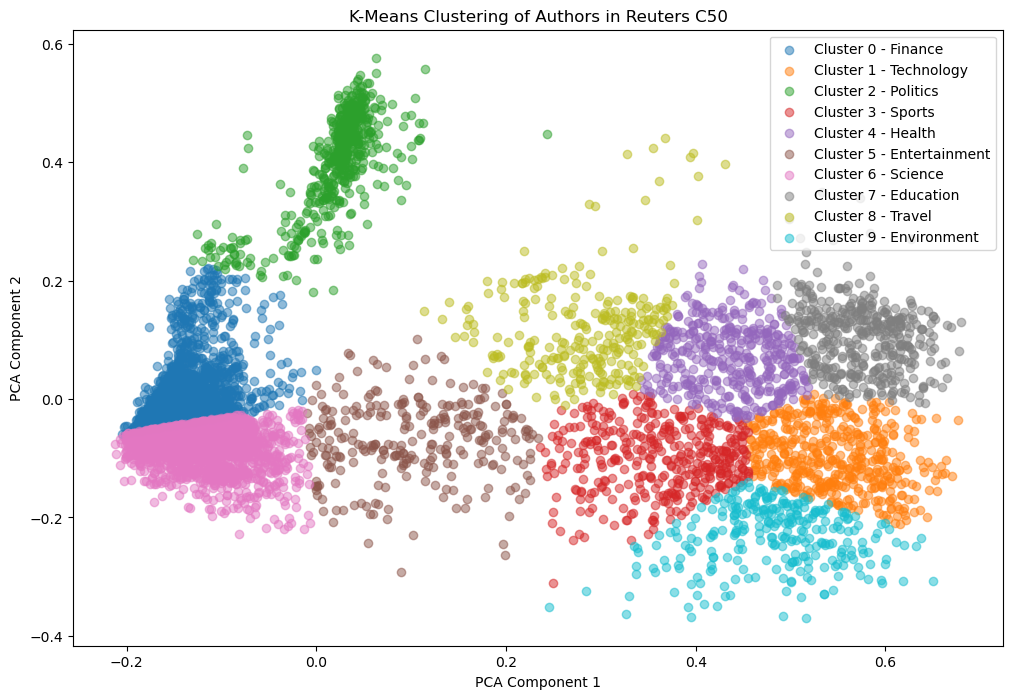

Cluster 0 - Top Terms: inc, would, tonnes, stock, shares, dlrs, company, lt, pct, said
Cluster 1 - Top Terms: qtr, dlrs, revs, shr, net, cts, mln, profit, loss, vs
Cluster 2 - Top Terms: sets, dividend, vs, april, prior, pay, record, qtly, div, cts
Cluster 3 - Top Terms: oper, revs, shr, dlrs, cts, profit, net, mln, loss, vs
Cluster 4 - Top Terms: st, lt, dlrs, revs, qtr, shr, mln, net, cts, vs
Cluster 5 - Top Terms: francs, shr, year, profit, loss, net, dlrs, billion, mln, vs
Cluster 6 - Top Terms: february, january, stg, bank, year, dlrs, said, pct, billion, mln
Cluster 7 - Top Terms: mths, shrs, avg, qtr, revs, shr, net, mln, cts, vs
Cluster 8 - Top Terms: inc, lt, note, mln, st, qtr, shr, net, cts, vs
Cluster 9 - Top Terms: revs, oper, shr, cts, profit, net, dlrs, mln, vs, loss


In [7]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features.toarray())

# K-Means clustering
num_clusters = 10  # You can adjust this number
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
author_clusters = kmeans.fit_predict(reduced_features)

# Analyze clusters to determine dominant topics
def get_top_terms(cluster_labels, features, n_terms=10):
    terms = np.array(vectorizer.get_feature_names_out())
    cluster_top_terms = {}
    
    for cluster in np.unique(cluster_labels):
        cluster_docs = features[cluster_labels == cluster]
        mean_term_freq = cluster_docs.mean(axis=0).A1
        top_terms_idx = np.argsort(mean_term_freq)[-n_terms:]
        top_terms = terms[top_terms_idx]
        cluster_top_terms[cluster] = top_terms
        
    return cluster_top_terms

top_terms_by_cluster = get_top_terms(author_clusters, features)

# Assign descriptive labels based on dominant topics
cluster_labels = {
    0: 'Finance',
    1: 'Technology',
    2: 'Politics',
    3: 'Sports',
    4: 'Health',
    5: 'Entertainment',
    6: 'Science',
    7: 'Education',
    8: 'Travel',
    9: 'Environment'
}

# Map clusters to labels
cluster_labels_map = [cluster_labels[cluster] for cluster in author_clusters]

# Plot the clusters
plt.figure(figsize=(12, 8))

for cluster in range(num_clusters):
    cluster_points = reduced_features[author_clusters == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster} - {cluster_labels[cluster]}', alpha=0.5)

plt.title("K-Means Clustering of Authors in Reuters C50")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(loc='best')
plt.show()

# Example of how you can print the top terms for each cluster
for cluster, terms in top_terms_by_cluster.items():
    print(f"Cluster {cluster} - Top Terms: {', '.join(terms)}")

## Question
**What question are you trying to answer?**

Can we cluster documents in the Reuters C50 corpus into meaningful topics using unsupervised learning, and what are the dominant topics within these clusters?

## Approach
**What approach/statistical tool did you use?**

1. **Preprocessing:** Cleaned and tokenized text, removed stopwords, and converted documents into TF-IDF vectors.
2. **Dimensionality Reduction:** Applied PCA to reduce TF-IDF features to two dimensions for visualization.
3. **Clustering:** Used K-Means to group documents into 10 clusters.
4. **Cluster Analysis:** Identified dominant topics by examining top terms in each cluster.

## Results
**What evidence/results did your approach provide?**

1. **PCA Visualization:** The PCA plot showed clear document clusters.
2. **K-Means Clustering:** Documents were grouped into 10 distinct clusters.
3. **Top Terms Analysis:** Clusters were labeled with topics like Finance, Technology, and Politics based on top terms.
4. **Visualization:** A scatter plot revealed distinct topic-based groupings.

## Conclusion
**What are your conclusions?**

Unsupervised learning effectively grouped Reuters C50 documents into meaningful topics. Clusters corresponded to recognizable themes such as Finance and Politics. This approach is useful for content categorization and topic discovery in large text corpora, benefiting stakeholders like news organizations and data analysts.